## Testing hypothesis 2
---

**_Hypothesis_**: Reviews with more positive sentiment words receive higher helpfulness ratings.

- **Metric**: Mean helpfulness ratings for number of positive and negative words.

- **Model**: Multinomial Naive Bayes.

- **Description**:

  - Use NBC as a classifier to predict the sentiment of a review.
  - Extract the most useful words from the classifier.
  - Compute the mean helpfulness ratings for the most useful words.  

**Missing Values**:

  - `review/score`: remove the entire sample
  - `review/text`: remove the entire sample
  - `review/helpfulness`: remove the entire sample

**Data Transformation**:

  - `review/score`: Assign 1 to score (4, 5), 0 to score (1, 2). 
  - `review/text`: Create the BoW for the text. Fit a MNBC and count the number of positive and negative words. Graphical Plot.
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$

---

In [1]:
import nltk
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats as stats

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/davide/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Connect to MongoDB


client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['book_reviews']

In [3]:
# Remove the samples if the fields reported above have missing values. Remove also the samples with score equal to 3, since it indicates a neutral review.
pipeline_remove = {'$match':
                   {
                       'review/text': {'$exists': True},
                       'review/score': {'$exists': True, '$ne': 3},
                       'Tot_votes': {'$exists': True, '$ne': 0}
                   }
                   }

# Create a new field called class. If the score is greater than 3, the class is 1, otherwise is 0.
pipeline_class = {'$project': {
    '_id': 0,
    'review/text': 1,
    'review/helpfulness_rate': {'$multiply': [
        {'$divide': ['$N_helpful', '$Tot_votes']},
        {'$sqrt': '$Tot_votes'}
    ]
    },
    'class': {
        '$cond': {
            'if': {'$in': ['$review/score', [4, 5]]},
            'then': 1,
            'else': 0
        }
    }
}
}

books_removed = books.aggregate([pipeline_remove, pipeline_class])
df = pd.DataFrame(list(books_removed))

In [4]:
# # Remove punctuation and convert to lowercase the review/text column
df['review/text'] = df['review/text'].replace('[^\w\s]', ' ', regex=True)
df['review/text'] = df['review/text'].str.lower()
df.head()

# # Remove stopwords from the review/text column
stop = stopwords.words('english')
df['review/text'] = df['review/text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop)]))
df.head()

# # Remove words with length less than 2 from the review/text column
df['review/text'] = df['review/text'].apply(
    lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
df.head()

,review/text,review/helpfulness_rate,class
0,self published book want know read paragraphs ...,0.707107,0
1,read review directly mine say laughed someone ...,1.666667,1
2,useful thorough text book would recommend anyo...,1.341641,1
3,thoroughly enjoyed rising sons daughters know ...,1.000000,1
4,sorry mistake could english first language dra...,2.236068,1


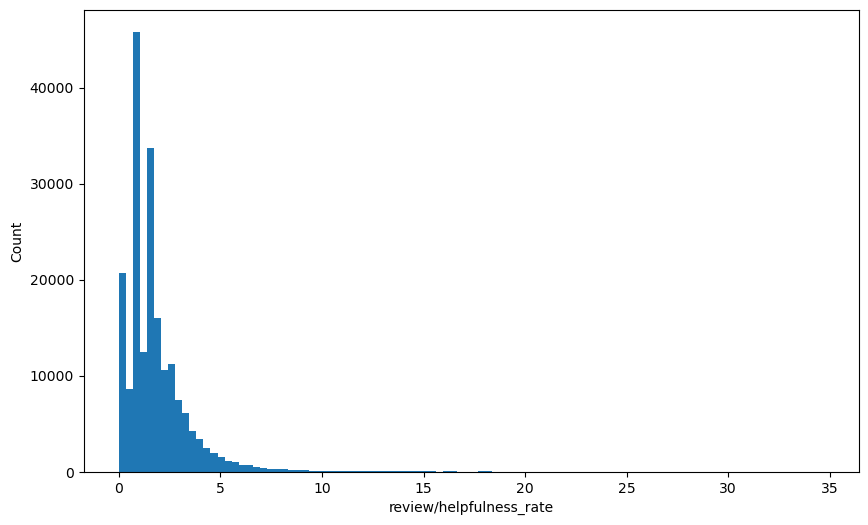

In [5]:
# # Plot the histogram of the helpful_score
plt.figure(figsize=(10, 6))
plt.hist(df['review/helpfulness_rate'], bins=100)
plt.xlabel('review/helpfulness_rate')
plt.ylabel('Count')
plt.show()

In [6]:
# dictionary of 2000 words
# # Build a bag of words
vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['review/text'])
y = df['class']

# # Train a Naive Bayes classifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

Word             1233
Pos_neg_ratio    1233
dtype: int64


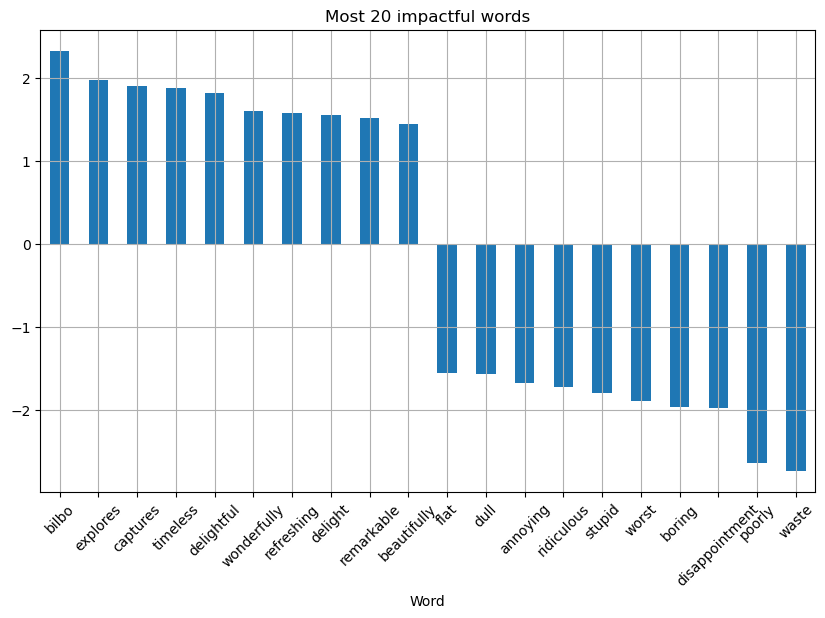

In [13]:
# # Print the most 20 positive words
feature_names = vectorizer.get_feature_names_out()
pos_neg_ratio = nb.feature_log_prob_[1, :] - nb.feature_log_prob_[0, :]
pos_neg_ratio_sorted = np.argsort(pos_neg_ratio)

words = pd.DataFrame({'Word': feature_names, 'Pos_neg_ratio': pos_neg_ratio})
words = words.sort_values(by='Pos_neg_ratio', ascending=False)
plot_words = pd.concat([words.head(10), words.tail(10)])

# Print the most 20 impactful words
plot_words.plot.bar(x='Word', y='Pos_neg_ratio', rot=45, figsize=(
    10, 6), grid=True, title='Most 20 impactful words', legend=False)
print(words[words['Pos_neg_ratio'] > 0].count())

Plot with 20 most positive words:
Correlation Coefficient: 0.2246140667473128
P-value: 0.0



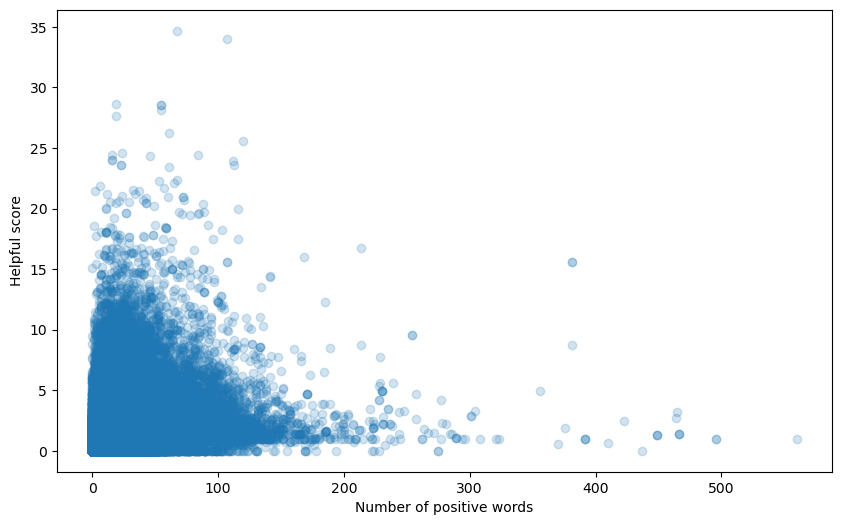

In [20]:
# # Create a new column with the number of positive words in the review/text column
print(f"Plot with 20 most positive words:")
df['positive_words'] = df['review/text'].apply(lambda x: len([word for word in x.split() if word in feature_names[pos_neg_ratio_sorted[-800:]]]))
df.head()

corr, pval = stats.kendalltau(df['positive_words'], df['review/helpfulness_rate'])
print(f'Correlation Coefficient: {corr}\nP-value: {pval}\n')

# # Plot the helpful_score vs the number of positive words in the review/text column
plt.figure(figsize=(10, 6))
plt.scatter(df['positive_words'], df['review/helpfulness_rate'], alpha=0.2)
plt.xlabel('Number of positive words')
plt.ylabel('Helpful score')
plt.show()

Group number: 10
Correlation Coefficient: 0.16323415032516717
P-value: 0.0



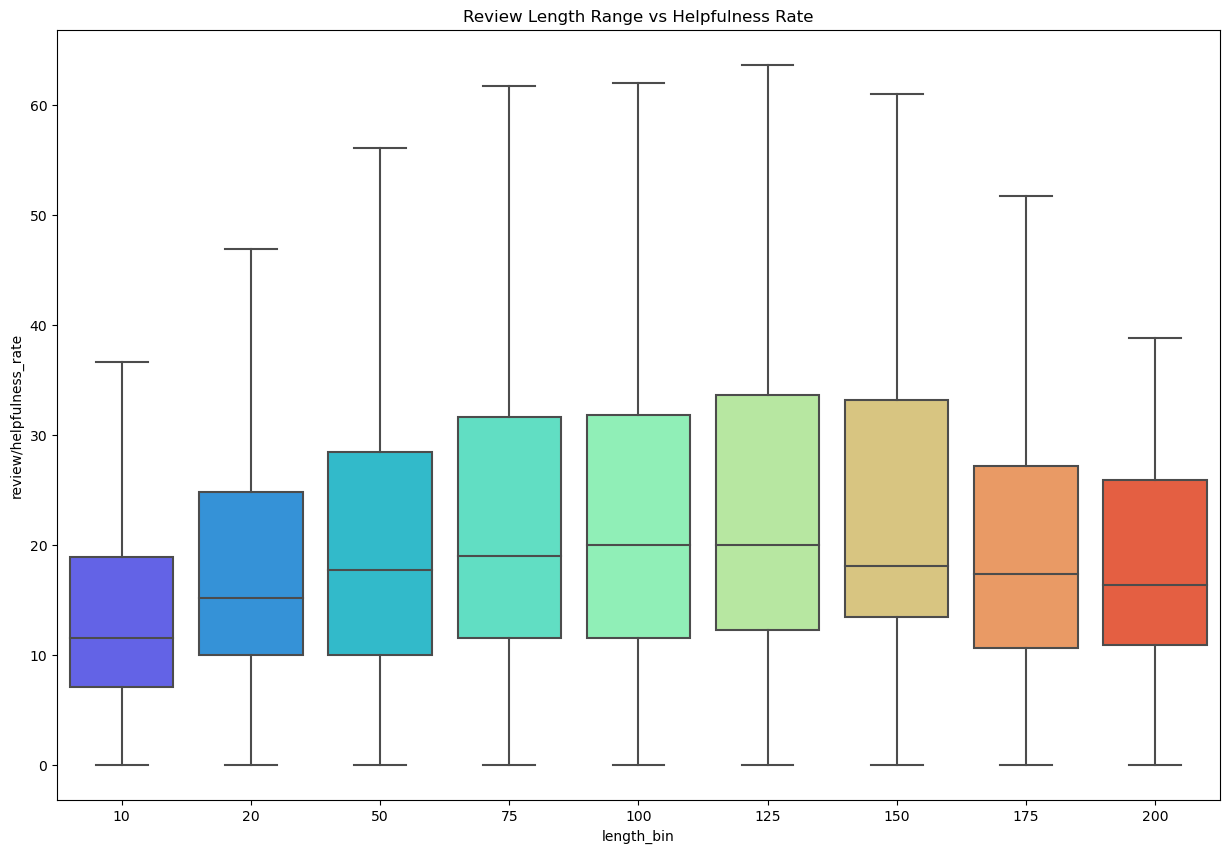

<Figure size 1500x1000 with 0 Axes>

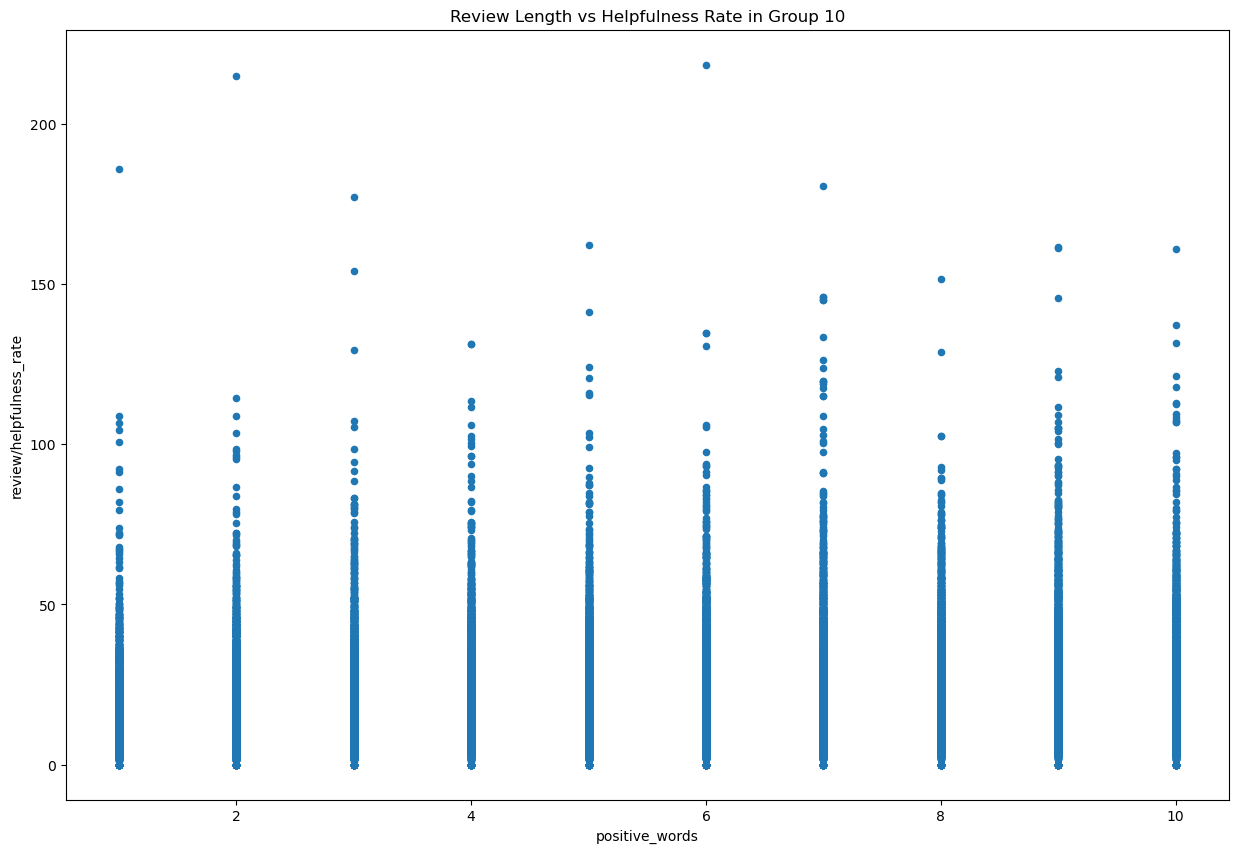

Group number: 20
Correlation Coefficient: 0.045778380690513584
P-value: 2.3422050398285327e-44



<Figure size 1500x1000 with 0 Axes>

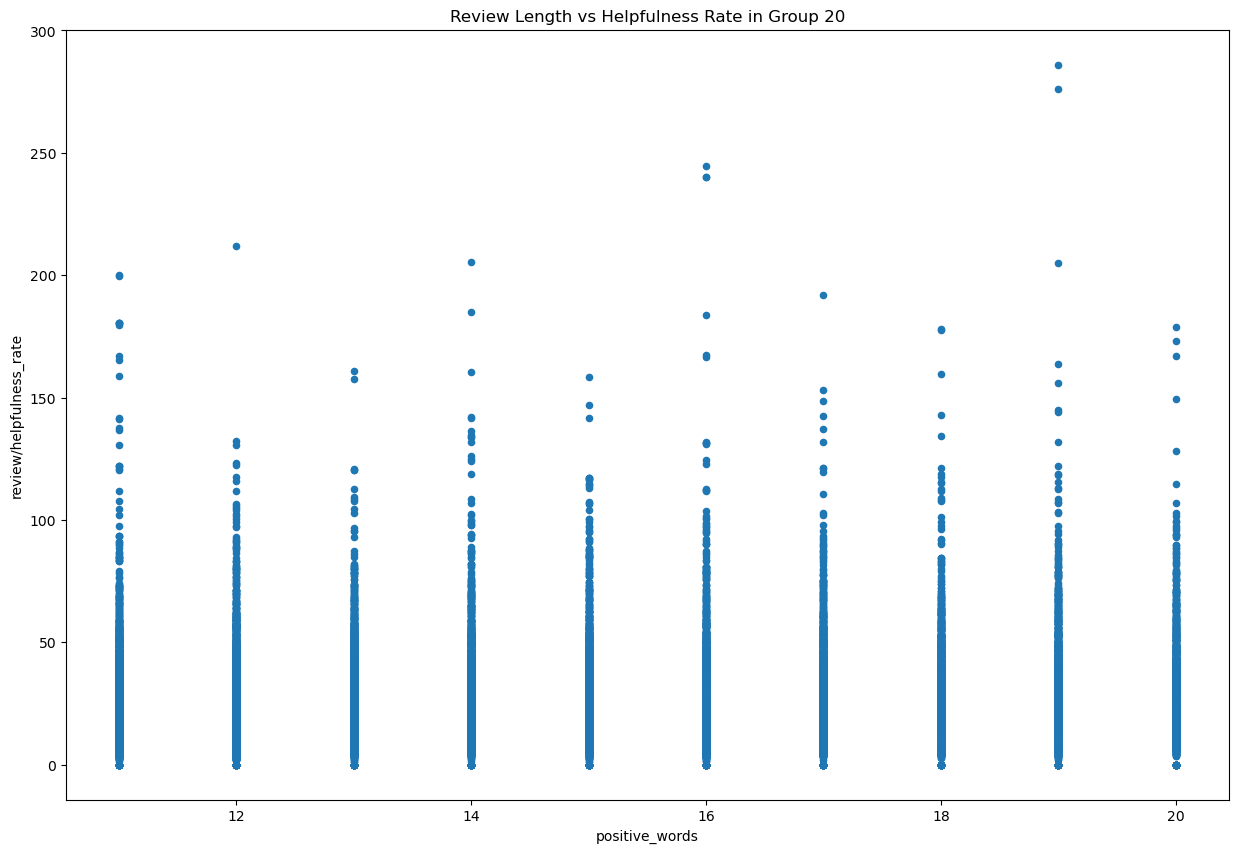

Group number: 50
Correlation Coefficient: 0.033596979810875574
P-value: 2.089504470915236e-21



<Figure size 1500x1000 with 0 Axes>

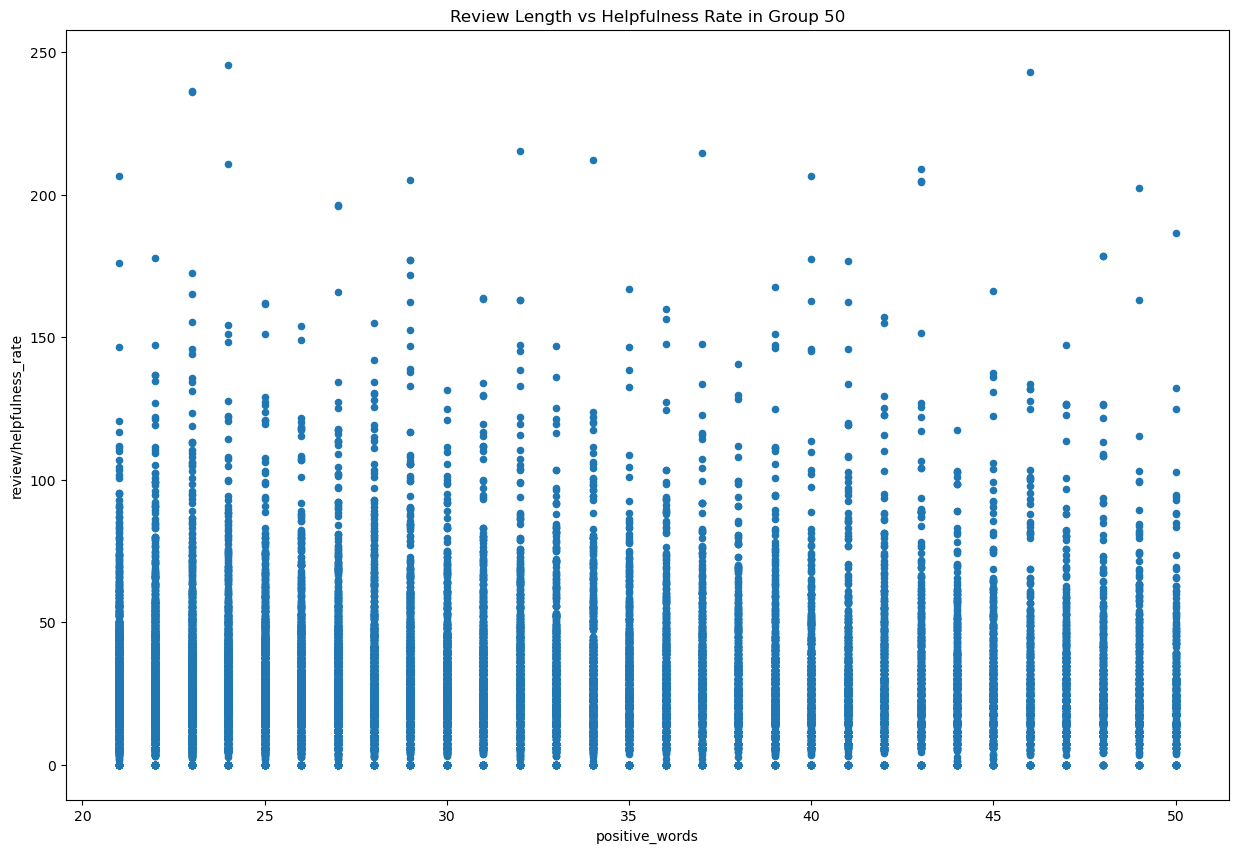

Group number: 75
Correlation Coefficient: 0.015446044597846669
P-value: 0.0664982779858169



<Figure size 1500x1000 with 0 Axes>

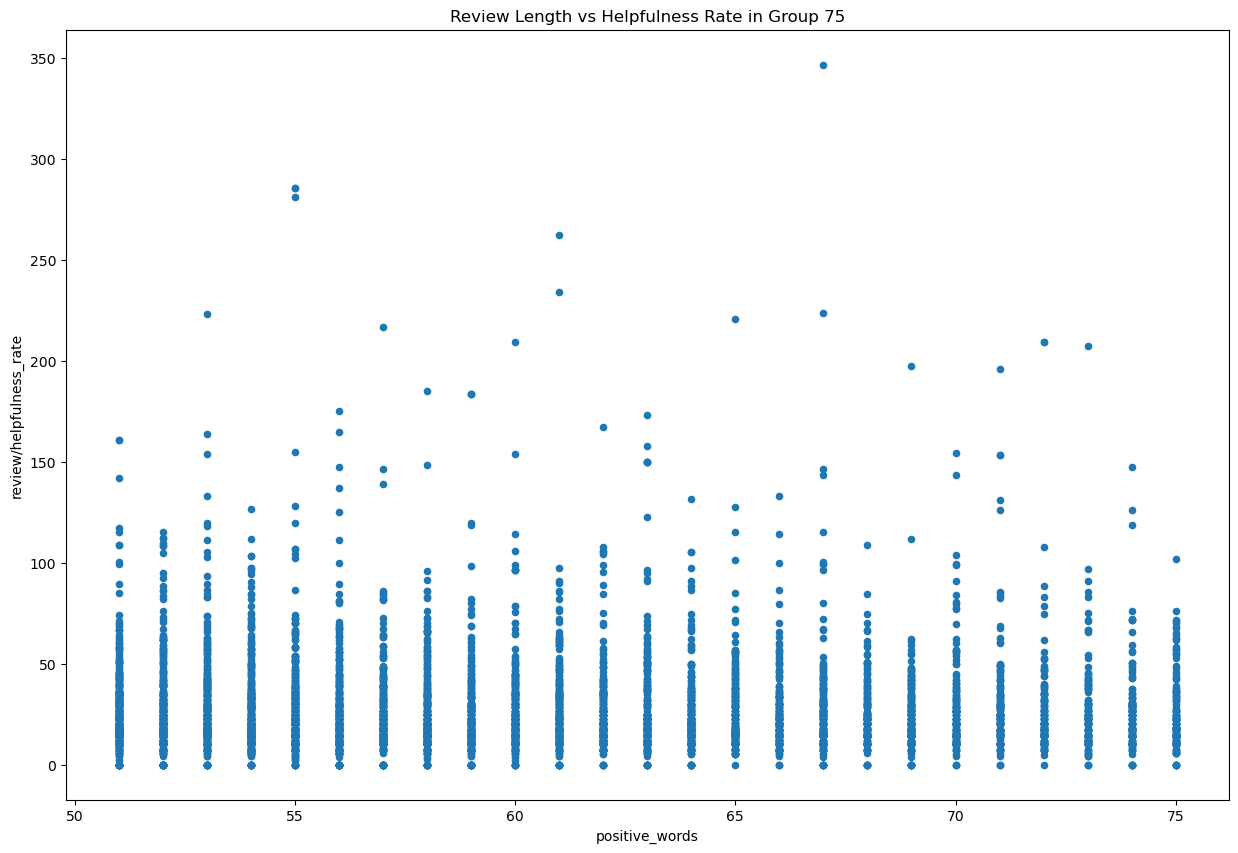

Group number: 100
Correlation Coefficient: 0.006731673725372276
P-value: 0.6405273310651829



<Figure size 1500x1000 with 0 Axes>

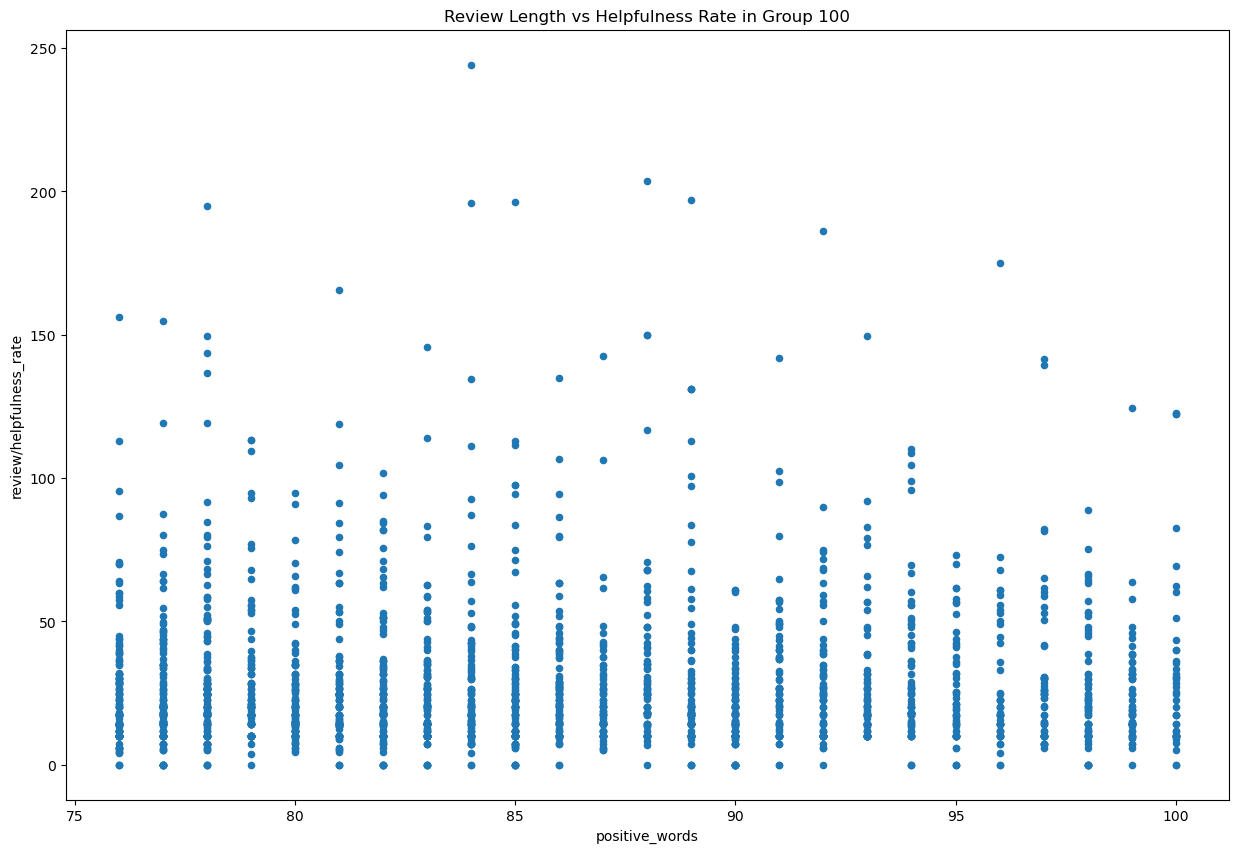

Group number: 125
Correlation Coefficient: -0.03467111626760091
P-value: 0.1644444387598717



<Figure size 1500x1000 with 0 Axes>

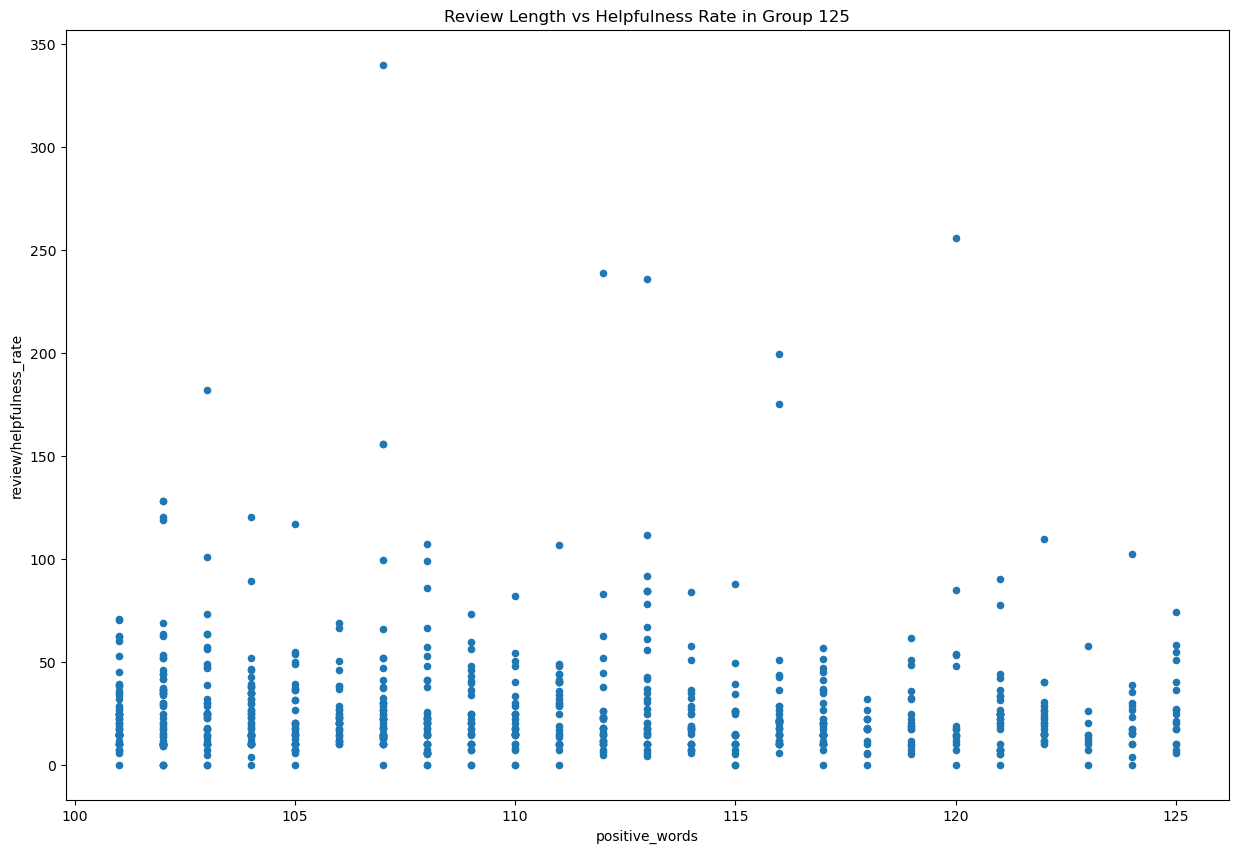

Group number: 150
Correlation Coefficient: 0.01859495554595066
P-value: 0.6549451872239546



<Figure size 1500x1000 with 0 Axes>

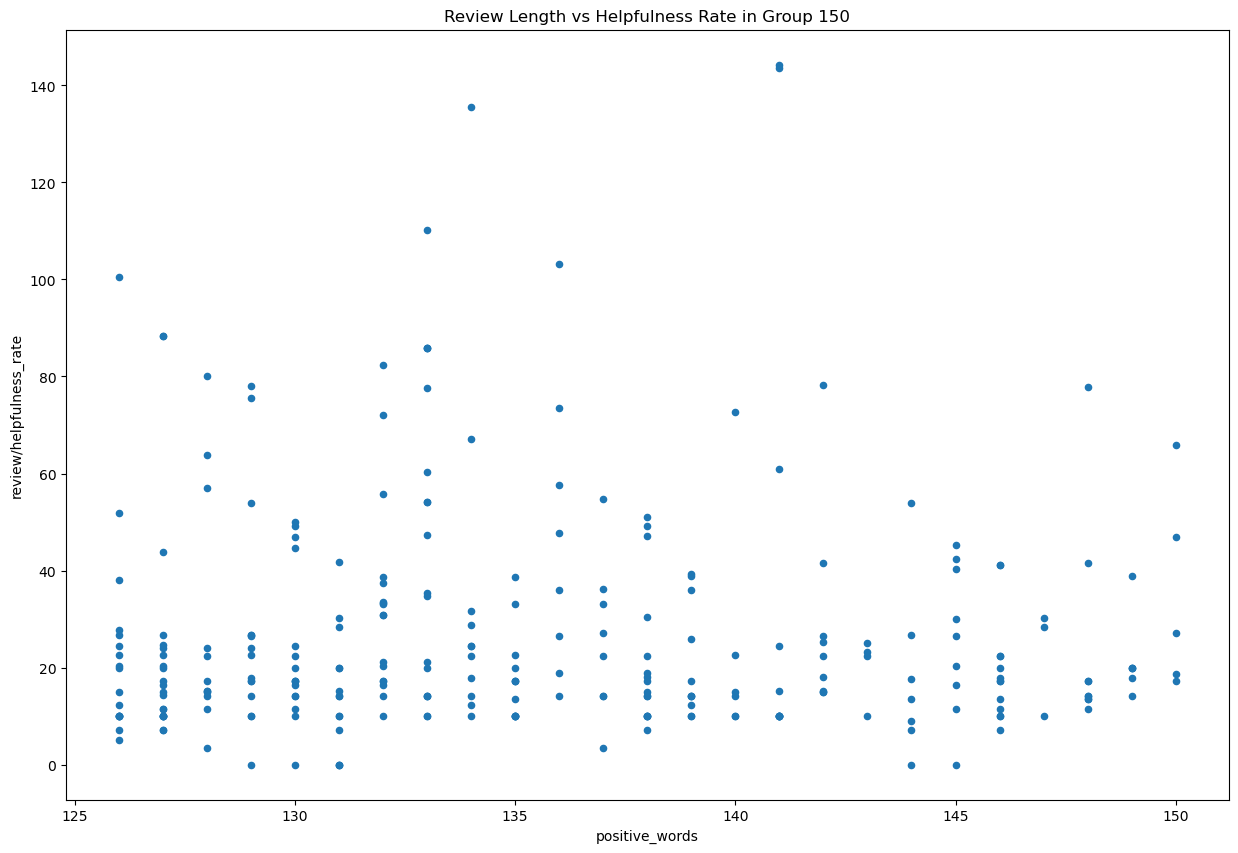

Group number: 175
Correlation Coefficient: -0.11513591939918688
P-value: 0.08384118111620524



<Figure size 1500x1000 with 0 Axes>

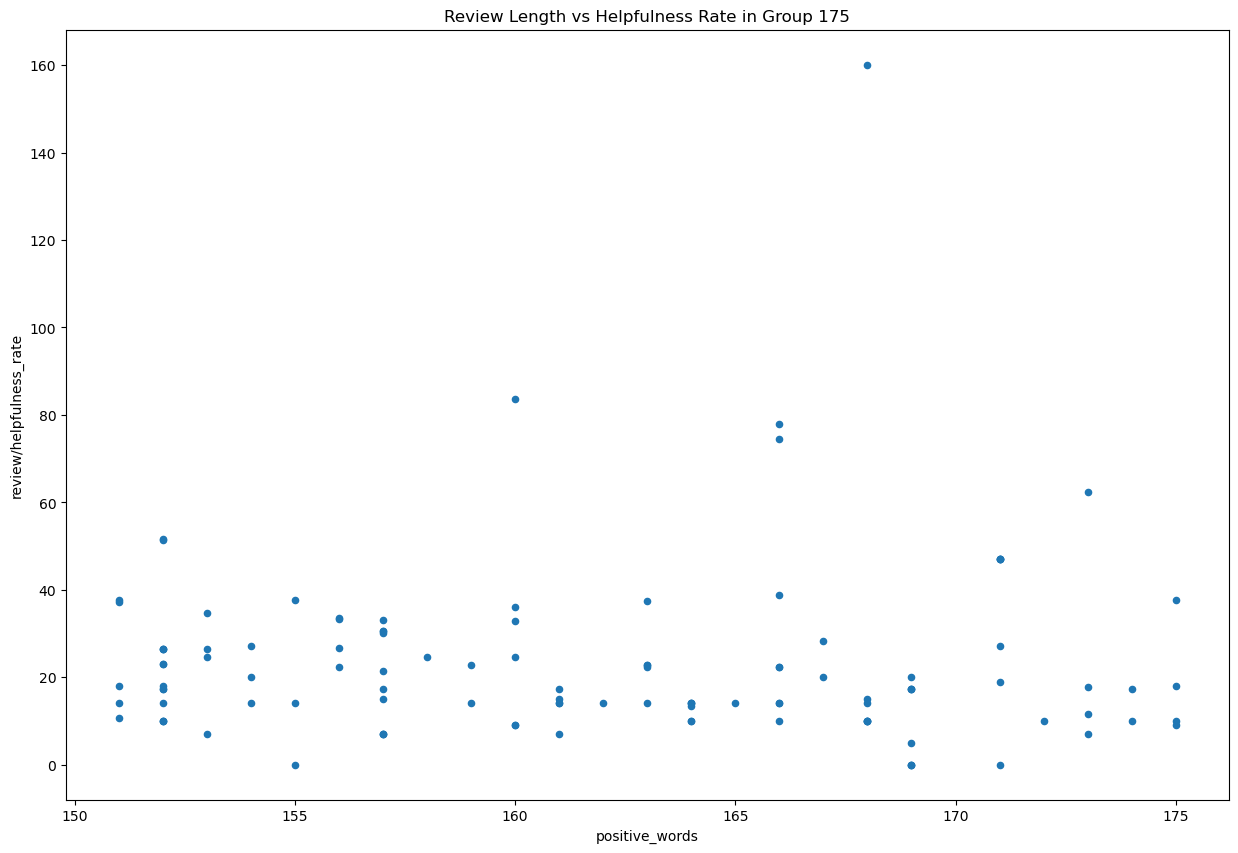

Group number: 200
Correlation Coefficient: 0.10380141919038548
P-value: 0.28654266305591336



<Figure size 1500x1000 with 0 Axes>

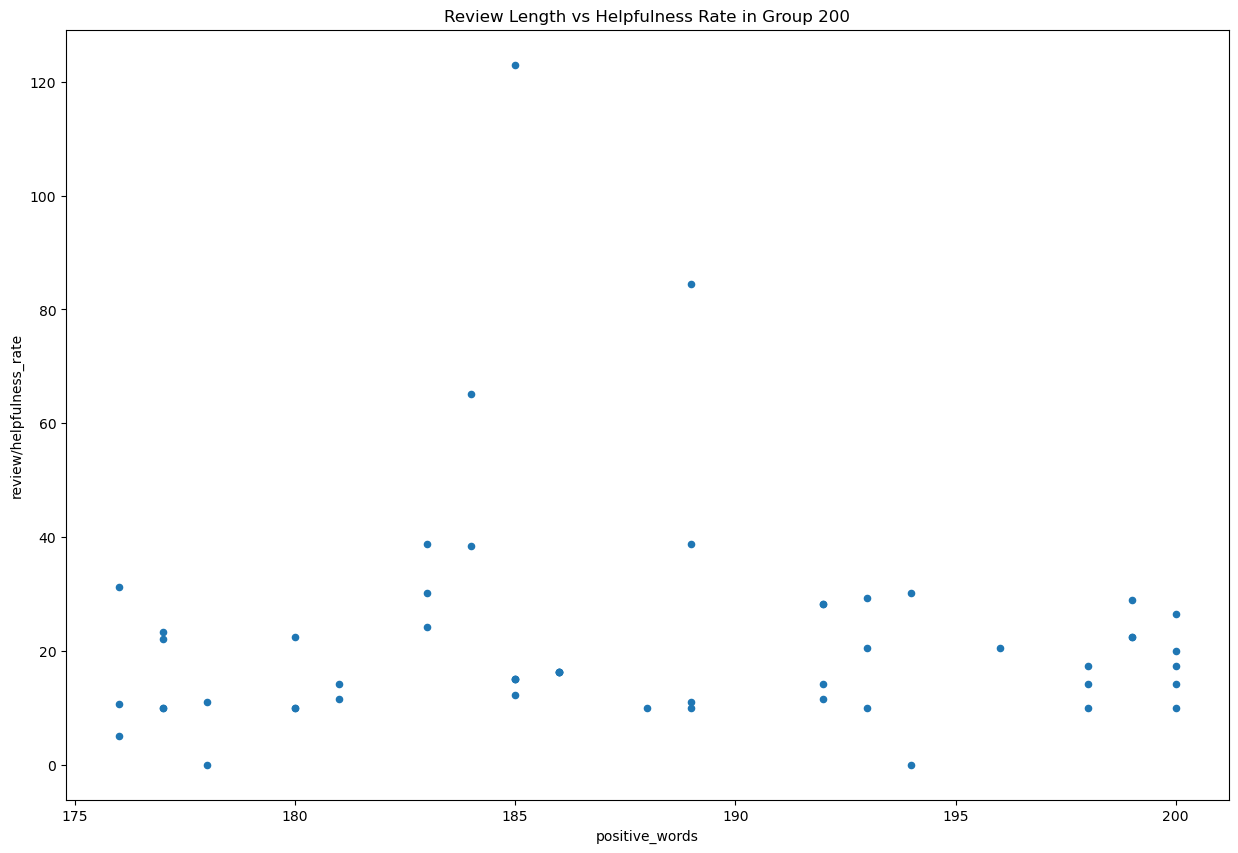

In [25]:
# Create 5 bins of positive_words
groups = [0, 10, 20, 50, 75, 100, 125, 150, 175, 200]
df['length_bin'] = pd.cut(df['positive_words'], bins=groups, labels=[
                          group for group in groups[1:]])

# Plot the distribution of positive_words with respect to helpfulness rate
plt.figure(figsize=(15, 10))
sns.boxplot(x='length_bin', y='review/helpfulness_rate',
            data=df, palette='rainbow',showfliers=False)
plt.title('Review Length Range vs Helpfulness Rate')

for el in groups[1:]:
    dataframe = df[df['length_bin'] == el]
    corr, pval = scipy.stats.kendalltau(
        dataframe['positive_words'], dataframe['review/helpfulness_rate'])
    print(
        f'Group number: {el}\nCorrelation Coefficient: {corr}\nP-value: {pval}\n')
    plt.figure(figsize=(15, 10))
    dataframe.plot(kind='scatter', x='positive_words', y='review/helpfulness_rate',
                   figsize=(15, 10), title=f'Review Length vs Helpfulness Rate in Group {el}')
    plt.show()

In [ ]:
client.close()